In [15]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import scipy.sparse
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import gensim
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, punkt
from gensim.models import KeyedVectors

import matplotlib.collections as plt1
import matplotlib.pyplot as plt2
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 50)

import pickle
import time
import re
import csv
import math
import pickle
import time
import spacy

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kno5cac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
#data frame with only labeled abstracts
df_lab = pd.read_csv("/home/kno5cac/git/publicrd/data/prd/Digital_abstract_labelled/labelled_abstracts.csv")

#data frame with all of the abstracts
df = pd.read_pickle("/home/kno5cac/git/publicrd/data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")

In [17]:
# Remove Null Abstracts. Reset the index and create a variable index to link with PROJECT_ID
df = df[~df.ABSTRACT.isnull()]
df.reset_index(inplace = True, drop = True)
df['index'] = df.index
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4


In [18]:
df_lab = df_lab[['PROJECT_ID','ABSTRACT','Is it related to Big-Data','label']]
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data


In [19]:
# merge with the labelled data using PROJECT_ID.
df['PROJECT_ID'] = pd.to_numeric(df['PROJECT_ID'])
df_merge = df.merge(df_lab[['PROJECT_ID','Is it related to Big-Data','label']], how='left', on='PROJECT_ID')
len(df_merge)

1143869

In [20]:
df_merge

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143864,1294186,Circadian rhythms are fundamental endogenous p...,NaN,Revealing the Palatable Meal-Inducible Circadi...,NSF,NSF,NaN,1931115,5/1/2020 12:00:00 AM,4/30/2025 12:00:00 AM,NaN,NaN,NaN,800771545,UNIVERSITY OF TEXAS SW MED CTR,NaN,NaN,NaN,NaN,NaN,NaN,47.074,2020,700000.0,NaN,1,0,700000.0,1,circadian_rhythm fundamental endogenous proper...,1143864,NaN,NaN
1143865,1294187,Recent research suggests that learning about g...,NaN,Collaborative Research : Improving the teachin...,NSF,NSF,NaN,1956119,7/1/2020 12:00:00 AM,6/30/2025 12:00:00 AM,NaN,NaN,NaN,170230239,UNIVERSITY OF TEXAS AUSTIN,NaN,NaN,NaN,NaN,NaN,NaN,47.076,2020,136238.0,NaN,3,0,672158.0,3,recent research suggest learn genetic high sch...,1143865,NaN,NaN
1143866,1294188,The COVID-19 pandemic has caused unprecedented...,NaN,Collaborative Research: RAPID: Maintain Mobili...,NSF,NSF,NaN,2028098,4/15/2020 12:00:00 AM,3/31/2021 12:00:00 AM,NaN,NaN,NaN,003387891,UNIVERSITY OF TENNESSEE KNOXVILLE,NaN,NaN,NaN,NaN,NaN,NaN,47.041,2020,132226.0,NaN,2,0,182205.0,2,covid_19_pandemic cause unprecedented disrupti...,1143866,NaN,NaN
1143867,1294189,Subduction zones – locations where one of the ...,NaN,Collaborative Research: Synthesiz

In [21]:
# Save project ID of labelled data
project_id_lab = list(df_lab['PROJECT_ID'])

# Get the index of labelled abstract
subset_df = df_merge.loc[df_merge['PROJECT_ID'].isin(project_id_lab),['index', 'PROJECT_ID']]
index_lab = list(subset_df['index'])

# 1. TFIDF approach

## 1.1. Vectorize, build the training and test sample

In [22]:
# Compute the TFIDF matrix on the full data
v = TfidfVectorizer()
tfidf = v.fit_transform(df['ABSTRACT'])

In [23]:
tfidf

<1143869x1307953 sparse matrix of type '<class 'numpy.float64'>'
	with 213160046 stored elements in Compressed Sparse Row format>

In [24]:
# Subset the TFIDF matrix on labelled data: select rows corresponding to the index
tfidf_lab = tfidf[index_lab,:]
tfidf_lab.shape

(1200, 1307953)

In [25]:
index_training = pd.read_csv('index_training.csv')
index_test = pd.read_csv('index_test.csv')

In [26]:
# convert to lists
index_training = list(index_training['0'])
index_test = list(index_test['0'])

In [27]:
# Build the training and test sample: randomly select 80% of index_lab as training and the rest as test
#import random

# Build the index for the training and the test
#index_training = random.sample(index_lab, int(0.8 * len(index_lab)))
#index_test = list(set(index_lab) - set(index_training))

# sort those index (sort help to extract the Y value for each set)
#index_training.sort()
#index_test.sort()

In [28]:
# Extract those index in the TFIDF matrix and compute the X training and Test
X_train_tfidf = tfidf[index_training,:]
X_test_tfidf = tfidf[index_test,:]

In [29]:
# Create Y for training and test using the index order from the sampling
Y_train_tfidf = [df_merge.loc[df_merge['index']== i,'label'].values.tolist() for i in index_training]
Y_train_tfidf = sum(Y_train_tfidf, [])

Y_test_tfidf = [df_merge.loc[df_merge['index']== i,'label'].values.tolist() for i in index_test]
Y_test_tfidf = sum(Y_test_tfidf, [])

## 1.2. KNN classifier

In [30]:
# number of neighbors
k = int(math.sqrt(len(Y_train_tfidf)))
print('Number of neighbors:', k)

Number of neighbors: 30


In [31]:
# Run KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors= k)
classifier.fit(X_train_tfidf,Y_train_tfidf)

KNeighborsClassifier(n_neighbors=30)

In [32]:
# Predict the classification
Y_pred_tfidf = classifier.predict(X_test_tfidf)

In [33]:
# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(Y_test_tfidf, Y_pred_tfidf)
#print(confusion)
print(classification_report(Y_test_tfidf, Y_pred_tfidf))

              precision    recall  f1-score   support

    Big-data       0.62      0.92      0.74        99
Non Big-data       0.91      0.60      0.73       141

    accuracy                           0.73       240
   macro avg       0.77      0.76      0.73       240
weighted avg       0.79      0.73      0.73       240



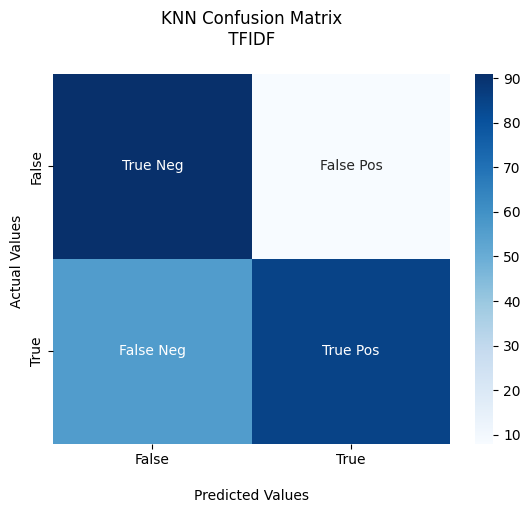

<Figure size 640x480 with 0 Axes>

In [34]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
ax.set_title('KNN Confusion Matrix\n TFIDF \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('tfidf_KNN.PNG')

In [35]:
# Predict the classification for the whole data: use the whole TFIDF
Y_tfidf = classifier.predict(tfidf)

# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_KNN'] = Y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN,Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN,Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN,Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN,Big-data


In [36]:
# Count the number of projects that is Big data related
df_bigdata = df_merge[df_merge['Prediction_KNN']=='Big-data']
print('Number of abstracts related to Big data:', len(df_bigdata))

Number of abstracts related to Big data: 386148


In [37]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

/tmp/ipykernel_83370/234042915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bigdata["FY"] = df_bigdata["FY"].astype('int')
/tmp/ipykernel_83370/234042915.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


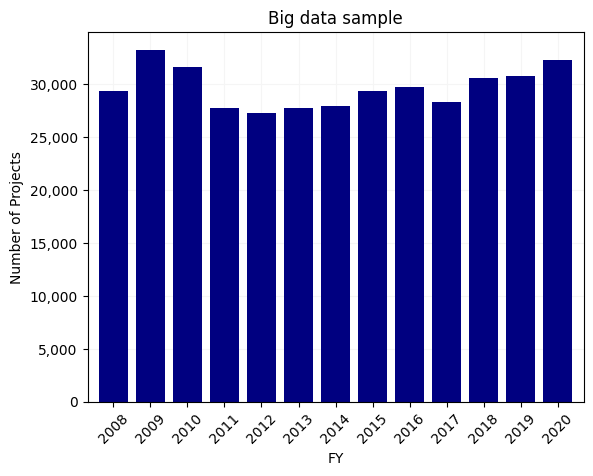

In [38]:
# Distribution over time and agencies
df_bigdata["FY"] = df_bigdata["FY"].astype('int')
year_counts = df_bigdata['FY'].value_counts().sort_index(ascending=True)

# Distribution
year = year_counts.index.tolist()
count = year_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
plt2.xlim(2007.3,2020.7)
plt2.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt2.xlabel("FY")
plt2.ylabel("Number of Projects")
plt2.title("Big data sample")

plt2.savefig("big_data_time.png", dpi = 800, bbox_inches = "tight")

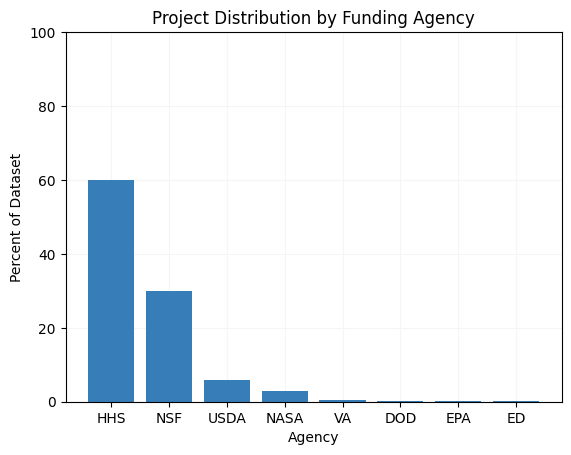

In [39]:
agency_counts = 100*df_bigdata["DEPARTMENT"].value_counts()/len(df_bigdata)
agency = agency_counts.index.tolist()
count = agency_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(agency, count, color=cb_pal['blue'])
plt2.ylim(0,100)
plt2.xlabel("Agency")
plt2.ylabel("Percent of Dataset")
plt2.title("Project Distribution by Funding Agency")

plt2.savefig("big_data_agency.png", dpi = 800, bbox_inches = "tight")

In [40]:
# save the data
#df_bigdata.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/tfidf_method.csv")

## 1.3. SVM

In [41]:
# We run SVM with default parameters provides by Sklearn. We train the model
from sklearn import svm
classifier_svm = svm.SVC()
classifier_svm.fit(X_train_tfidf,Y_train_tfidf)

SVC()

In [42]:
# Predict the classification
Y_pred_tfidf = classifier_svm.predict(X_test_tfidf)

In [43]:
# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(Y_test_tfidf, Y_pred_tfidf)
#print(confusion)
print(classification_report(Y_test_tfidf, Y_pred_tfidf))

              precision    recall  f1-score   support

    Big-data       0.89      0.64      0.74        99
Non Big-data       0.79      0.94      0.86       141

    accuracy                           0.82       240
   macro avg       0.84      0.79      0.80       240
weighted avg       0.83      0.82      0.81       240



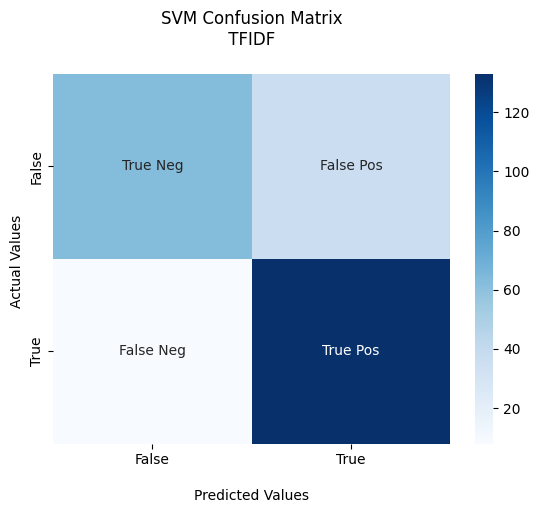

<Figure size 640x480 with 0 Axes>

In [44]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
ax.set_title('SVM Confusion Matrix\n TFIDF \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('tfidf_SVM.PNG')

In [45]:
# Predict the classification for the whole data: use the whole TFIDF
Y_tfidf = classifier_svm.predict(tfidf)

# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_SVM'] = Y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN,Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN,Big-data,Non Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN,Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN,Big-data,Non Big-data


In [46]:
# Cross comparision between SVM and KNN
pd.crosstab(df_merge['Prediction_KNN'], df_merge['Prediction_SVM'], margins=True, margins_name="Total")

Prediction_SVM,Big-data,Non Big-data,Total
Prediction_KNN,,,
Big-data,22925,363223,386148
Non Big-data,66,757655,757721
Total,22991,1120878,1143869


## 1.4. Decision Tree

In [47]:
# Use default parameters provides by SKLearn and train the model
from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(X_train_tfidf,Y_train_tfidf)

DecisionTreeClassifier()

In [48]:
# Predict the classification
Y_pred_tfidf = classifier_DT.predict(X_test_tfidf)

In [49]:
# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(Y_test_tfidf, Y_pred_tfidf)
#print(confusion)
print(classification_report(Y_test_tfidf, Y_pred_tfidf))

              precision    recall  f1-score   support

    Big-data       0.74      0.75      0.74        99
Non Big-data       0.82      0.82      0.82       141

    accuracy                           0.79       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.79      0.79      0.79       240



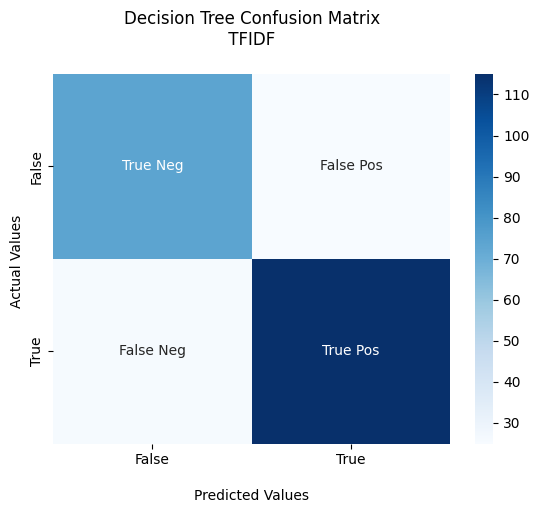

<Figure size 640x480 with 0 Axes>

In [50]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
ax.set_title('Decision Tree Confusion Matrix\n TFIDF \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('tfidf_DT.PNG')

In [51]:
# Predict the classification for the whole data: use the whole TFIDF
Y_tfidf = classifier_DT.predict(tfidf)

# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_DT'] = Y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN,Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN,Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN,Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN,Big-data,Non Big-data,Non Big-data


In [52]:
# Cross comparision between NN and SVM
pd.crosstab(df_merge['Prediction_DT'], df_merge['Prediction_SVM'], margins=True, margins_name="Total")

Prediction_SVM,Big-data,Non Big-data,Total
Prediction_DT,,,
Big-data,10637,67149,77786
Non Big-data,12354,1053729,1066083
Total,22991,1120878,1143869


In [53]:
# Cross comparision between NN and KNN
pd.crosstab(df_merge['Prediction_DT'], df_merge['Prediction_KNN'], margins=True, margins_name="Total")

Prediction_KNN,Big-data,Non Big-data,Total
Prediction_DT,,,
Big-data,50025,27761,77786
Non Big-data,336123,729960,1066083
Total,386148,757721,1143869


## 1.5. Random Forest

In [54]:
# Use default parameters provides by SKLearn and train the model
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train_tfidf,Y_train_tfidf)

RandomForestClassifier()

In [55]:
# Predict the classification
Y_pred_tfidf = classifier_RF.predict(X_test_tfidf)

In [56]:
# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(Y_test_tfidf, Y_pred_tfidf)
#print(confusion)
print(classification_report(Y_test_tfidf, Y_pred_tfidf))

              precision    recall  f1-score   support

    Big-data       0.84      0.60      0.70        99
Non Big-data       0.76      0.92      0.84       141

    accuracy                           0.79       240
   macro avg       0.80      0.76      0.77       240
weighted avg       0.80      0.79      0.78       240



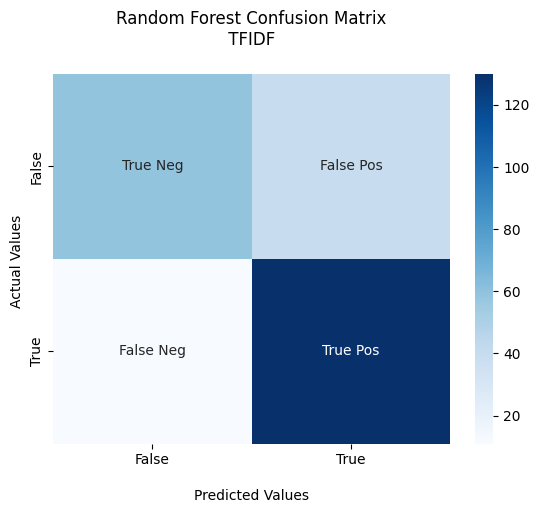

<Figure size 640x480 with 0 Axes>

In [57]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
ax.set_title('Random Forest Confusion Matrix\n TFIDF \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('tfidf_RF.PNG')

In [58]:
# Predict the classification for the whole data: use the whole TFIDF
Y_tfidf = classifier_RF.predict(tfidf)

# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_RF'] = Y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data


In [59]:
# Cross comparision between RF and DT
pd.crosstab(df_merge['Prediction_RF'], df_merge['Prediction_DT'], margins=True, margins_name="Total")

Prediction_DT,Big-data,Non Big-data,Total
Prediction_RF,,,
Big-data,13396,31032,44428
Non Big-data,64390,1035051,1099441
Total,77786,1066083,1143869


In [60]:
# Cross comparision between RF and SVM
pd.crosstab(df_merge['Prediction_RF'], df_merge['Prediction_SVM'], margins=True, margins_name="Total")

Prediction_SVM,Big-data,Non Big-data,Total
Prediction_RF,,,
Big-data,14693,29735,44428
Non Big-data,8298,1091143,1099441
Total,22991,1120878,1143869


In [61]:
# Cross comparision between RF and SVM
pd.crosstab(df_merge['Prediction_RF'], df_merge['Prediction_KNN'], margins=True, margins_name="Total")

Prediction_KNN,Big-data,Non Big-data,Total
Prediction_RF,,,
Big-data,41977,2451,44428
Non Big-data,344171,755270,1099441
Total,386148,757721,1143869


## 1.6. Neural network classifier

In [62]:
# Use default parameters provides by SKLearn and train the model
from sklearn.neural_network import MLPClassifier
classifier_nn = MLPClassifier()
classifier_nn.fit(X_train_tfidf,Y_train_tfidf)

MLPClassifier()

In [63]:
# Predict the classification
Y_pred_tfidf = classifier_nn.predict(X_test_tfidf)

In [64]:
# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(Y_test_tfidf, Y_pred_tfidf)
#print(confusion)
print(classification_report(Y_test_tfidf, Y_pred_tfidf))

              precision    recall  f1-score   support

    Big-data       0.74      0.66      0.70        99
Non Big-data       0.78      0.84      0.81       141

    accuracy                           0.76       240
   macro avg       0.76      0.75      0.75       240
weighted avg       0.76      0.76      0.76       240



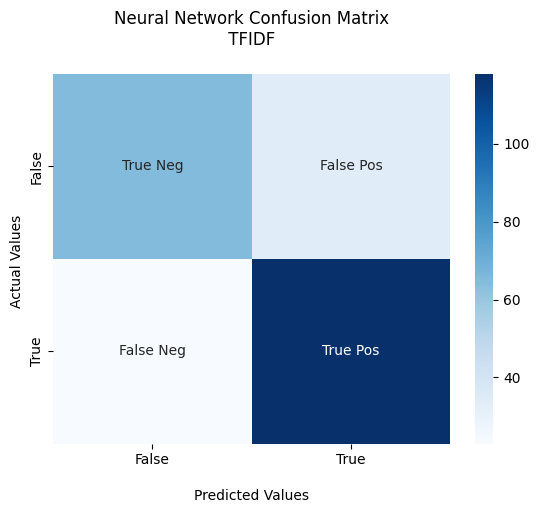

<Figure size 640x480 with 0 Axes>

In [65]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
ax.set_title('Neural Network Confusion Matrix\n TFIDF \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('tfidf_NN.PNG')

In [66]:
# Predict the classification for the whole data: use the whole TFIDF
Y_tfidf = classifier_nn.predict(tfidf)

# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_NN'] = Y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data


In [67]:
# Cross comparision between NN and KNN
pd.crosstab(df_merge['Prediction_NN'], df_merge['Prediction_KNN'], margins=True, margins_name="Total")

Prediction_KNN,Big-data,Non Big-data,Total
Prediction_NN,,,
Big-data,85598,3552,89150
Non Big-data,300550,754169,1054719
Total,386148,757721,1143869


In [68]:
# Cross comparision between NN and SVM
pd.crosstab(df_merge['Prediction_NN'], df_merge['Prediction_SVM'], margins=True, margins_name="Total")

Prediction_SVM,Big-data,Non Big-data,Total
Prediction_NN,,,
Big-data,20937,68213,89150
Non Big-data,2054,1052665,1054719
Total,22991,1120878,1143869


In [69]:
# Cross comparision between NN and DT
pd.crosstab(df_merge['Prediction_NN'], df_merge['Prediction_DT'], margins=True, margins_name="Total")

Prediction_DT,Big-data,Non Big-data,Total
Prediction_NN,,,
Big-data,21336,67814,89150
Non Big-data,56450,998269,1054719
Total,77786,1066083,1143869


In [70]:
# Cross comparision between NN and RF
pd.crosstab(df_merge['Prediction_NN'], df_merge['Prediction_RF'], margins=True, margins_name="Total")

Prediction_RF,Big-data,Non Big-data,Total
Prediction_NN,,,
Big-data,30517,58633,89150
Non Big-data,13911,1040808,1054719
Total,44428,1099441,1143869


In [71]:
# save the data
df_merge.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/FR_final_predicted_tfidf.csv")

## 1.7. Decision rule based on all classifiers

In [72]:
# Compute a score to be identify as big data
df_merge = pd.read_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/FR_final_predicted.csv")
df_merge['score'] = np.where(df_merge['Prediction_KNN'].str.contains("Non Big-data"), 0, 1) + np.where(df_merge['Prediction_SVM'].str.contains("Non Big-data"), 0, 1) + np.where(df_merge['Prediction_DT'].str.contains("Non Big-data"), 0, 1) + np.where(df_merge['Prediction_RF'].str.contains("Non Big-data"), 0, 1) + np.where(df_merge['Prediction_NN'].str.contains("Non Big-data"), 0, 1)

/tmp/ipykernel_83370/2300387315.py:2: DtypeWarning: Columns (3,7,8,11,12,13,14,16,17,18,19,20,21,22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merge = pd.read_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/FR_final_predicted.csv")


In [73]:
df_merge.head()

,Unnamed: 0,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN,score
0,0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",1.0,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data,1
1,1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",2.0,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Big-data,2
2,2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",4.0,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data,1
3,3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",4.0,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data,0
4,4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22.0,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Non Big-data,2


In [74]:
# Distribution of abstracts
df_merge['score'].value_counts()

0    738966
1    287333
2     77573
3     23219
4     11514
5      5264
Name: score, dtype: int64

In [75]:
# Used a rule (majority votes from classifiers) to identify Big-data abstracts. Useful because we have an impair number of classifier
df_merge['Big_data'] = 0
df_merge.loc[df_merge['score']>3,'Big_data'] = 1
df_merge['Big_data'].value_counts()

0    1127091
1      16778
Name: Big_data, dtype: int64

In [76]:
# subset the data to big-data and save
df_bigdata = df_merge[df_merge['Big_data']==1]
df_bigdata.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/abstracts_classification_big_data.csv")

PermissionError: [Errno 13] Permission denied: '/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/abstracts_classification_big_data.csv'

## Descriptive statistics of our Big data

/tmp/ipykernel_83370/1793649044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bigdata["FY"] = df_bigdata["FY"].astype('int')
/tmp/ipykernel_83370/1793649044.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


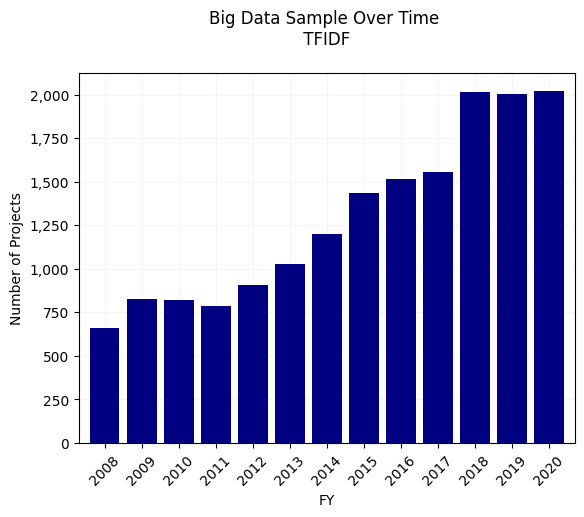

In [77]:
# Distribution over time and agencies
df_bigdata["FY"] = df_bigdata["FY"].astype('int')
year_counts = df_bigdata['FY'].value_counts().sort_index(ascending=True)

# Distribution
year = year_counts.index.tolist()
count = year_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
plt2.xlim(2007.3,2020.7)
plt2.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt2.xlabel("FY")
plt2.ylabel("Number of Projects")
plt2.title("Big Data Sample Over Time \n TFIDF \n")

plt2.savefig("big_data_time.png", dpi = 800, bbox_inches = "tight")

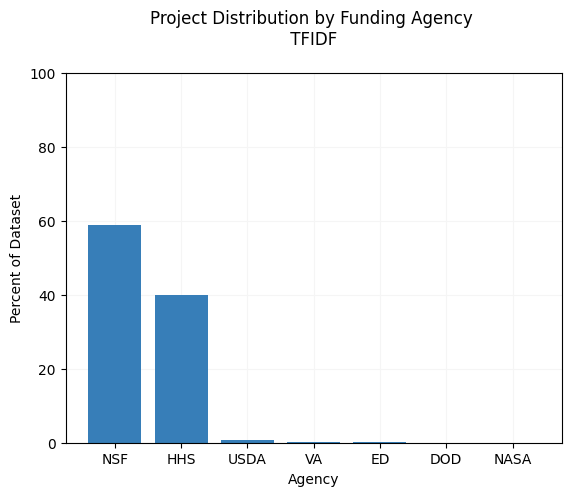

In [78]:
agency_counts = 100*df_bigdata["DEPARTMENT"].value_counts()/len(df_bigdata)
agency = agency_counts.index.tolist()
count = agency_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(agency, count, color=cb_pal['blue'])
plt2.ylim(0,100)
plt2.xlabel("Agency")
plt2.ylabel("Percent of Dataset")
plt2.title("Project Distribution by Funding Agency \n TFIDF \n")

plt2.savefig("big_data_agency.png", dpi = 800, bbox_inches = "tight")